In [1]:
import sys
import os


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
import matplotlib.pyplot as plt
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg
ds = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./files/",
        transform=torchvision.transforms.ToTensor(),download=True
    ),
    
    batch_size=500
)
import numpy as np
images = []
for _, batch in enumerate(ds):
    label = np.array(batch[1])
    batch_nines = label == 3
    images.append(np.array(batch[0])[batch_nines])
images = np.concatenate(images)

ds = torch.utils.data.TensorDataset(torch.Tensor(images))
d1, d2 = (torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True, ) for _ in (1,1))



Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/democonf_settings.js

In [3]:
import matplotlib.pyplot as plt

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RegisNet(nn.Module):
    def __init__(self):
        super(RegisNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(12, 10, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(22, 10, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(42, 10, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(52, 2, kernel_size=5, padding=2)

    def forward(self, x, y):
        x= torch.cat([x, y], 1)
        
        x = torch.cat([x, F.relu(self.conv1(x))], 1)
        x = torch.cat([x, F.relu(self.conv2(x))], 1)
        x = torch.cat([x, F.relu(self.conv3(x))], 1)
        x = torch.cat([x, F.relu(self.conv4(x))], 1)
        x = torch.cat([x, F.relu(self.conv5(x))], 1)
        
        return self.conv6(x)
    
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.dense1 = nn.Linear(28 * 28 * 2, 8000)
        self.dense2 = nn.Linear(8000, 3000)
        self.dense3 = nn.Linear(3000, 28 * 28 * 2)
    def forward(self, x, y):
        x = torch.reshape(torch.cat([x, y], 1), (-1, 2 * 28 * 28))
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        x = torch.reshape(x, (-1, 2, 28, 28))
        return x
        


class MermaidNet(nn.Module):
    def __init__(self):
        super(MermaidNet, self).__init__()       
        
        self.sz = np.array([128, 1, 28, 28])
        self.spacing = 1./(self.sz[2::]-1) 
        
        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
       
        
        self.regis_net = RegisNet().cuda()
        
        self.lambdaNet_old = RegisNet().cuda()
        self.lambdaNet_old.conv6.weight.data.fill_(0)
        self.lambdaNet_old.conv6.bias.data.fill_(0)
        self.lambdaNet = RegisNet().cuda()
        self.mu = 5
        

    def forward(self, moving_image, fixed_image):
        

        self.phi1 = self.regis_net(moving_image, fixed_image) + self.identityMap
        
        self.phiinv = self.regis_net(fixed_image, moving_image) + self.identityMap
        
        self.warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, self.phi1, self.spacing, 1)
        
        self.warped_fixed_image = py_utils.compute_warped_image_multiNC(
            fixed_image, self.phiinv, self.spacing, 1)
        
        self.fake_ident = py_utils.compute_warped_image_multiNC(
            self.phiinv, self.phi1, self.spacing, 1)
        
        lambda_old = self.lambdaNet_old(moving_image, fixed_image).detach()
                
        regularization_loss = (
            .5 * self.mu * torch.mean(
                (self.identityMap - self.fake_ident)**2
            ) - torch.mean(
                 lambda_old * 
                (self.identityMap - self.fake_ident)
            )
        )
        similarity_loss = (
            torch.mean((self.warped_moving_image - fixed_image)**2) + 
            torch.mean((self.warped_fixed_image - moving_image)**2)
        )
        
        self.all_loss = regularization_loss + similarity_loss
        
        self.lambda_loss = torch.mean((lambda_old - self.mu * (
            self.identityMap - self.fake_ident.detach())
            - self.lambdaNet(moving_image, fixed_image))**2)
        print("ll", self.lambda_loss.item())
        
        
    def update_lambda(self):
        self.lambdaNet_old.load_state_dict(self.lambdaNet.state_dict())
    


net = MermaidNet()
0

0

In [66]:
net.mu = 150

In [67]:
main_optimizer = torch.optim.Adam(net.parameters(), lr=.0001)
lambda_optimizer = torch.optim.Adam(net.lambdaNet.parameters(), lr=.001)

In [68]:
net.train()

MermaidNet(
  (regis_net): RegisNet(
    (conv1): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(12, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(22, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv4): Conv2d(32, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv5): Conv2d(42, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv6): Conv2d(52, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (lambdaNet_old): RegisNet(
    (conv1): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(12, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(22, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv4): Conv2d(32, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv5): Conv2d(42, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv6): Conv2d(52, 2, kernel_size=(5, 5), stride=(1, 1), pa

In [69]:
for _ in range(100):
    print("doo")
    for _ in range(10):
        print("dep")
        for moving, fixed in list(zip(d1, d2)):
            if moving[0].size()[0] == 128:
                moving_image = moving[0].cuda()
                fixed_image = fixed[0].cuda()
                main_optimizer.zero_grad()
                lambda_optimizer.zero_grad()
                net(moving_image, fixed_image)
                loss = net.all_loss

                loss.backward()

                main_optimizer.step()
                
                lambda_loss = net.lambda_loss
                lambda_loss.backward()
                lambda_optimizer.step()
        print(loss.item())
    net.update_lambda()


doo
dep
ll 5.648860454559326
ll 45.58274841308594


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


ll 9.483736038208008
ll 20.17206382751465
ll 23.151212692260742
ll 15.170053482055664
ll 12.057356834411621
ll 10.763504981994629
ll 11.902575492858887
ll 10.926483154296875
ll 10.734689712524414
ll 9.316054344177246
ll 8.450222969055176
ll 8.919267654418945
ll 9.965034484863281
ll 9.766362190246582
ll 8.314498901367188
ll 6.787673473358154
ll 6.088244915008545
ll 6.627584934234619
ll 8.366045951843262
ll 7.55425500869751
ll 6.006808280944824
ll 6.0397725105285645
ll 6.409655570983887
ll 6.404736518859863
ll 5.79768180847168
ll 6.3360209465026855
ll 5.224139213562012
ll 5.797707557678223
ll 5.984080791473389
ll 5.4635772705078125
ll 5.263706207275391
ll 5.299227714538574
ll 5.107605934143066
ll 5.304887771606445
ll 5.685805320739746
ll 5.598484516143799
ll 5.192960262298584
ll 4.910242080688477
ll 5.205851078033447
ll 5.573022842407227
ll 5.376682281494141
ll 5.176291465759277
ll 4.819408893585205
ll 5.512753009796143
ll 5.534117221832275
0.03806567192077637
dep
ll 5.046250343322754
ll

ll 3.312947988510132
ll 3.5304954051971436
ll 3.4184086322784424
ll 3.218510150909424
ll 3.6073553562164307
ll 3.3573215007781982
ll 3.0961217880249023
ll 3.472254991531372
ll 3.2761893272399902
ll 3.019268751144409
ll 3.493610143661499
ll 3.3598878383636475
ll 3.2669780254364014
ll 3.1316306591033936
ll 3.7624857425689697
ll 3.8192336559295654
ll 3.5069808959960938
ll 2.9372994899749756
ll 3.125863552093506
ll 3.219651460647583
ll 3.29239821434021
ll 3.372032880783081
ll 3.390777111053467
ll 3.493032693862915
ll 3.372856855392456
ll 3.2448654174804688
ll 3.2632622718811035
ll 3.306133270263672
ll 3.3400931358337402
ll 3.430558443069458
ll 3.096681833267212
ll 3.5675406455993652
ll 3.2062911987304688
ll 3.8272128105163574
ll 3.6907496452331543
ll 3.9588828086853027
ll 3.234302043914795
ll 3.3045785427093506
ll 3.4200618267059326
ll 3.266369104385376
ll 3.418170690536499
0.029822938144207
dep
ll 3.296616554260254
ll 3.3914003372192383
ll 3.352982997894287
ll 3.0259673595428467
ll 2.9878

ll 2.7899489402770996
ll 2.9546146392822266
ll 2.7741050720214844
ll 3.037351608276367
ll 3.175563097000122
ll 3.1194937229156494
ll 3.0835938453674316
ll 2.8199517726898193
ll 2.782311201095581
ll 2.849547863006592
ll 2.815828800201416
ll 2.9729433059692383
ll 2.760514497756958
ll 2.8681552410125732
ll 2.842395544052124
ll 3.1446211338043213
ll 2.7207348346710205
ll 2.8023030757904053
ll 2.7302606105804443
ll 2.6314854621887207
ll 3.419924020767212
ll 2.927725315093994
ll 2.973684549331665
ll 2.9444589614868164
ll 3.124580144882202
ll 2.7192904949188232
ll 3.0676605701446533
ll 2.934593915939331
ll 3.090430736541748
ll 2.8283164501190186
ll 2.685973644256592
ll 2.808749198913574
ll 2.723237991333008
ll 2.7079520225524902
ll 3.1596364974975586
ll 2.8045785427093506
ll 3.1779592037200928
ll 2.892223596572876
ll 2.8493478298187256
ll 2.6514225006103516
ll 2.6376006603240967
0.027010507881641388
dep
ll 2.9936373233795166
ll 2.988494396209717
ll 2.6973016262054443
ll 2.5932509899139404
ll 

ll 2.7979953289031982
ll 2.584562063217163
ll 2.8572239875793457
ll 2.72159743309021
ll 2.5901432037353516
ll 2.7342000007629395
ll 2.7868494987487793
ll 2.3923492431640625
ll 2.4858882427215576
ll 2.4777331352233887
ll 2.811123847961426
ll 2.5782432556152344
ll 2.7285261154174805
ll 2.414956569671631
ll 2.742375612258911
ll 2.4182393550872803
ll 2.5732970237731934
ll 2.6292407512664795
ll 2.875368595123291
ll 2.7527546882629395
ll 2.7934978008270264
ll 2.797852039337158
ll 2.75132155418396
ll 2.3717057704925537
ll 2.720888137817383
ll 2.458303213119507
ll 2.605668306350708
ll 2.785003900527954
ll 2.4571282863616943
ll 2.534083843231201
ll 2.7167716026306152
ll 2.805884838104248
ll 2.7238824367523193
ll 2.8617300987243652
ll 2.692643165588379
ll 2.614933490753174
ll 2.7123239040374756
ll 2.22967267036438
ll 2.9602906703948975
ll 2.7423388957977295
ll 2.577228307723999
ll 2.4191842079162598
0.026146836578845978
dep
ll 2.6402587890625
ll 2.58786940574646
ll 2.352933645248413
ll 2.5475642

KeyboardInterrupt: 

ll 2.638185501098633


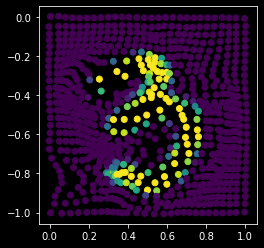

In [70]:
moving, fixed = list(zip(d1, d2))[0]
moving_image = moving[0].cuda()
fixed_image = fixed[0].cuda()

net(moving_image, fixed_image)

phi = np.array((net.phi1).cpu().detach())
iden = np.array(net.identityMap.cpu())

#N = 0

N += 1
plt.style.use("dark_background")
l = 0
a = l * iden + (1 - l) * phi
plt.axes().set_aspect('equal')
plt.scatter(a[N][1].flatten(), -a[N][0].flatten(), 
            c=fixed_image[N, 0].cpu().numpy().flatten())

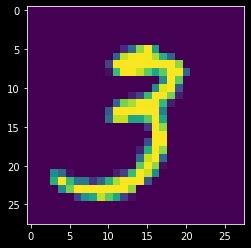

In [71]:
plt.imshow(fixed_image[N, 0].cpu().numpy())

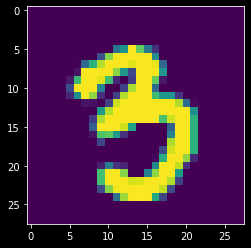

In [72]:
plt.imshow(moving_image[N, 0].cpu().numpy())

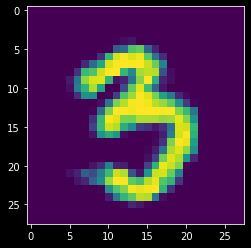

In [73]:
plt.imshow(net.warped_fixed_image[N, 0].detach().cpu())

In [74]:
def get_phi(a, b):
    net(a, b)
    return net.phi1.detach().cpu()

In [75]:
phi2 = get_phi(fixed_image, moving_image)
phi1 = get_phi(moving_image, fixed_image)


ll 2.7891886234283447
ll 2.638185501098633


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


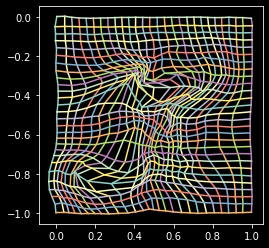

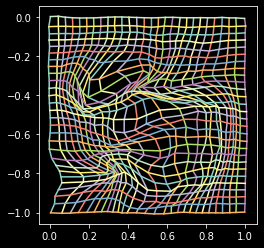

In [76]:
def grid(A, B):
    plt.axes().set_aspect("equal")
    plt.plot(A, B)
    plt.plot(A.transpose(0, 1), B.transpose(0, 1))
    
def grd(d):
    grid(d[1], d[0])


grid(phi2[N, 1], -phi2[N, 0])
plt.show()
grid(phi1[N, 1], -phi1[N, 0])

In [77]:
grid

<function __main__.grid(A, B)>

In [78]:
ident_hope = py_utils.compute_warped_image_multiNC(phi2, phi1, net.spacing, 1)

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


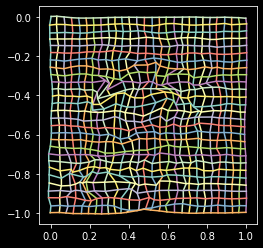

In [79]:
grid(ident_hope[N, 1], -ident_hope[N, 0])

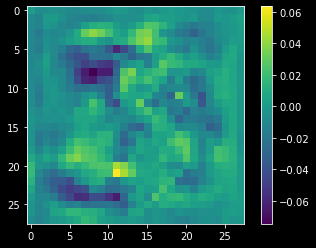

In [64]:
plt.imshow(ident_hope[N, 1] - iden[N, 1])
plt.colorbar()

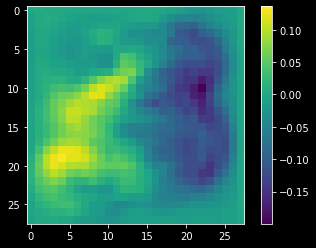

In [65]:
plt.imshow(phi2[N, 1] - iden[N, 1])
plt.colorbar()

In [50]:
net.phi.size()

AttributeError: 'MermaidNet' object has no attribute 'phi'

In [68]:
grid(phi1)

TypeError: grid() missing 1 required positional argument: 'B'

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


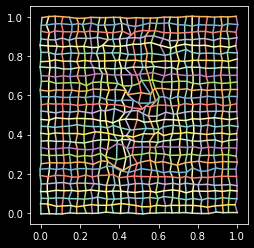

In [609]:
phi1_inv = py_utils.compute_warped_image_multiNC(phi2, phi1, net.spacing, 1)
grd(phi1_inv[N])

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


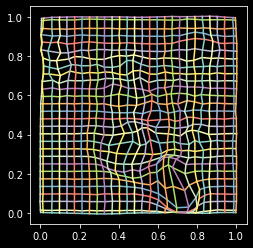

In [97]:
id_ = net.identityMap.cpu().numpy()

phi1_disp = phi1.numpy() - id_

mphi1 = id_ - phi1_disp

phi1inv = py_utils.compute_warped_image_multiNC(phi1, torch.tensor(mphi1), net.spacing, 1)

grd(phi1inv[N])

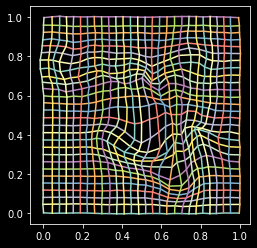

In [98]:
grd(phi2[N])

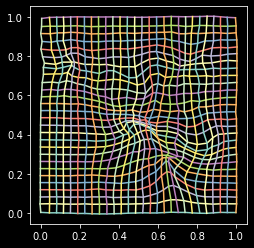

In [100]:
grd(phi1[N])

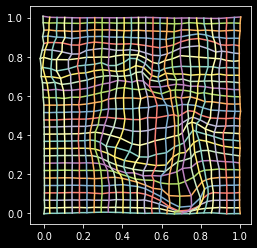

In [105]:
grd(torch.tensor(mphi1)[N])

In [104]:
phi1.shape

torch.Size([128, 2, 28, 28])

In [199]:
x = net.lambdaNet(fixed_image, moving_image).cpu().detach().numpy()

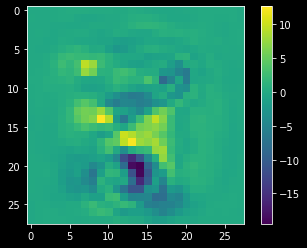

In [203]:
plt.imshow(x[3, 1])
plt.colorbar()